# Reto 4

## Andrea Castiella Aguirrezabala y Miguel Eduardo Ortiz Huamani

## Unzip
Utilizado en Google Colab

In [15]:
#!unzip dataset.zip

## Imports

In [1]:
import numpy as np
import OurUtils as our
from PIL import Image

# Visualizacion
import matplotlib.pyplot as plt

# Carga de datos
import pandas as pd
import os

# Tensorflow
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, ReLU
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras


## Load data
### Data augmentation
En esta sección se han utilizado, además de las imágenes originales, las imágenes aumentadas surgidas del empleo del código ``data_aug.py``. 
Con este proceso se consigue un aumento del accuracy de validación de un 20-30% en comparación al entrenamiento únicamente con las imágenes originales.

### Cargar rutas imágenes originales

In [2]:
class_names = ["aula", "cocina", "dormitorio", "oficina"]
data_path = "dataset"
train_im_names = [(os.listdir(os.path.join(data_path, label))) for label in class_names]
train_im_names = np.unique(np.hstack(np.array(train_im_names)))
train_im_names = list(train_im_names)
index_aug = train_im_names.index("augmented")
train_im_names.pop(index_aug)
train_im_names = np.array(train_im_names)
train_im_labels = np.array([class_names.index(name[:-3]) for name in train_im_names])
print(train_im_names, train_im_names.shape)
print(train_im_labels, train_im_labels.shape)

['aula001' 'aula002' 'aula003' ... 'oficina398' 'oficina399' 'oficina400'] (1600,)
[0 0 0 ... 3 3 3] (1600,)


### Cargar rutas de imágenes de data_aug.py

In [3]:
train_im_names_aug = [(os.listdir(os.path.join(data_path, label, "augmented"))) for label in class_names]
train_im_names_aug = np.hstack(np.array(train_im_names_aug))
train_im_labels_aug = np.array([class_names.index(name.split(".")[0][:-5]) for name in train_im_names_aug])
train_im_labels = np.hstack([train_im_labels, train_im_labels_aug])
train_im_names = np.hstack([train_im_names, train_im_names_aug])

## Separar datos en entrenamiento y validación
- train: 80%
- val: 20%

In [4]:
test_size = .2
random_state = 123
X_train, Y_train, X_test, Y_test = our.single_stratified_split(train_im_names, train_im_labels, test_size=test_size, random_state=random_state)
print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_test.shape[0])
print("Example val")
print(X_test[0:5])
print(Y_test[0:5])

Training set size:  5120
Validation set size:  1280
Example val
['dormitorio290_2.JPEG' 'oficina399_1.JPEG' 'aula294' 'aula355_0.JPEG'
 'cocina167_1.JPEG']
[2 3 0 0 1]


## Lectura de imágenes

In [5]:
get_name = lambda x: x[:-3] if len(x.split(".")) == 1 else (x[:-10] + "/augmented")
X_train = [np.array(Image.open(os.path.join(data_path, get_name(name), name))) for name in X_train]
X_test = [np.array(Image.open(os.path.join(data_path, get_name(name), name))) for name in X_test]

## Image shape differences
- Definir input size del modelo

In [6]:
# En caso de que alguna imagen tenga un número de canales distinto a 3.
for i in range(len(X_train)):
    h,w,c = X_train[i].shape 
    if c != 3:
        X_train[i] = X_train[i][:,:,:3]

for i in range(len(X_test)):
    h,w,c = X_test[i].shape 
    if c != 3:
        X_test[i] = X_test[i][:,:,:3]


h = []
w = []
for i in range(len(X_train)):
    im_shape = X_train[i].shape
    h.append(im_shape[0])
    w.append(im_shape[1])


# Búsqueda de un tamaño de imagen medio para rescalar todas las imágenes a este valor.
h = np.array(h)
w = np.array(w)
print("h: ", np.unique(h), np.mean(h))
print("w: ", np.unique(w), np.mean(w))
# h: 148 | w: 154

h:  [ 59  68  72  75  81  85  87  90  91  92  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179] 146.046484375
w:  [ 65  72  74  85  92  97 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 184 185 188 190 191 192 193
 197 198 200 201 204 205 206 208 210 212 214 215 216 217 219 221 222 223
 224 227 229 230 231 233 234 238 239 240 241 242 244 246 248 250 253 255
 256 257 258 259 260 261 263 264 268 269 271 273 274 275 278 279 280 283
 28

## Visualize data

(150, 150, 3)


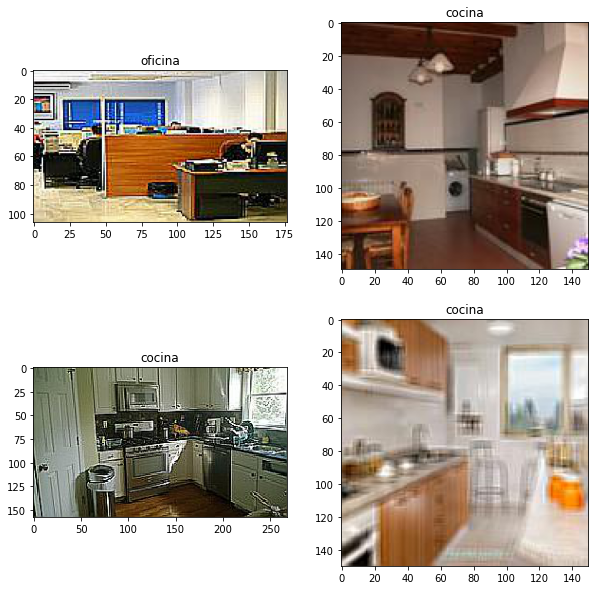

In [7]:
print(X_train[390].shape)
plt.figure(figsize=(10,10))

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax1 = plt.subplot(2,2,1)
ax1.title.set_text(class_names[img_label])
plt.imshow(img_in)

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text(class_names[img_label])
plt.imshow(img_in)

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text(class_names[img_label])
plt.imshow(img_in)

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text(class_names[img_label])
plt.imshow(img_in)

plt.show()

## Process data

In [8]:
# normalize and resize
resize_rescales = tf.keras.Sequential(
    [layers.experimental.preprocessing.Resizing(148,154),
    layers.experimental.preprocessing.Rescaling(1./255)]
)

# Data augmentation. Al final se usa un script externo: data_aug.py
# data_augmentation = tf.keras.Sequential([
#   layers.RandomFlip("horizontal"),
#   #layers.RandomRotation(0.2),
# ])

# Resize rescale
for i in range(len(X_train)):
    # X_train[i] = data_augmentation(X_train[i])
    X_train[i] = resize_rescales(X_train[i])

for i in range(len(X_test)):
    # X_test[i] = data_augmentation(X_test[i])
    X_test[i] = resize_rescales(X_test[i])


## Model
En esta sección se crean los modelos utilizados para las pruebas. Finalmente se usa el modelo OurRedReto4, compuesta por tres capas de convoluciones seguidas de un BatchNormalization y tres capas densas con dropout para intentar evitar el overfitting. 

In [9]:
# modelos

# conv + conv + conv + fc + fc
class OurRedReto4(Model):
  def __init__(self, feat_filters):
    super(OurRedReto4, self).__init__()
    self.conv1 = Conv2D(filters=feat_filters[0],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')

    self.conv2 = Conv2D(filters=feat_filters[1],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')

    self.conv3 = Conv2D(filters=feat_filters[2],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')


    self.batch1 = BatchNormalization(epsilon=1e-05, momentum=0.1)
    self.batch2 = BatchNormalization(epsilon=1e-05, momentum=0.1)
    self.batch3 = BatchNormalization(epsilon=1e-05, momentum=0.1)

    # self.feat_dimensions = () # algo 
    self.flatten = keras.layers.Flatten()
    #self.maxpool=tf.nn.max_pool(2,2)
    # self.max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
    #    strides=(1, 1), padding='valid')

    self.fc1 = Dense(128,activation="relu")
    self.fc2 = Dense(256,activation="relu")
    self.fc3 = Dense(4,activation="softmax")
    self.dropout = layers.Dropout(.4)

  def call(self,x):
    x = self.conv1(x)
    x = self.batch1(x)
    # x = self.max_pool_2d(x)
    x = self.conv2(x)
    x = self.batch2(x)
    # x = self.max_pool_2d(x)
    x = self.conv3(x)
    x = self.batch3(x)
    # x = self.max_pool_2d(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)
    x = self.fc3(x)
    return x

# conv + batch + relu + conv + batch + relu + fc + fc
class OurResnet(Model):
  def __init__(self, feat_filters):
    super(OurResnet, self).__init__()
    self.conv0 = Conv2D(filters=feat_filters[0],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.conv1 = Conv2D(filters=feat_filters[1],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.conv2 = Conv2D(filters=feat_filters[2],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    # Utilizado como paso intermedio en caso de que los bloques tengan convoluciones de distintos tamaños.
    # self.conv3 = Conv2D(filters=feat_filters[3],
    #            kernel_size=3,
    #            activation='relu',
    #            strides=1,
    #            padding='same')

    self.conv4 = Conv2D(filters=feat_filters[4],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')
    
    self.conv5 = Conv2D(filters=feat_filters[4],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.batch1 = BatchNormalization(epsilon=1e-05, momentum=0.1)
    self.batch2 = BatchNormalization(epsilon=1e-05, momentum=0.1)

    self.Relu = ReLU()

    self.flatten = keras.layers.Flatten()

    self.dropout = layers.Dropout(.4)

    self.fc1 = Dense(128,activation="relu")
    self.fc2 = Dense(4,activation="softmax")

  def call(self,x):

    x = self.conv0(x)
    
    # Primer bloque resnet
    xin = tf.identity(x)
    x = self.conv1(x)
    x = self.batch1(x)
    x = self.Relu(x)
    x = self.conv2(x)
    x = self.batch1(x)
    x = xin + x
    x = self.Relu(x)

    # Segundo bloque resnet
    x = self.conv3(x)
    xin = tf.identity(x)
    x = self.conv4(x)
    x = self.batch2(x)
    x = self.Relu(x)
    x = self.conv5(x)
    x = self.batch2(x)
    x = xin + x
    x = self.Relu(x)

    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

## Trainer
- optimizer
- loss function
- metrics

### Loss function
>There are three kinds of classification tasks:
>Binary classification: two exclusive classes, you need to use binary cross entropy
>Multi-class classification: more than two exclusive classes, you need to use categorical cross entropy.
>Multi-label classification: just non-exclusive classes,you need to use binary cross entropy.

Para el Reto4, nos encontramos con el caso de Multi-class classification, por lo tanto la función de pérdida usada es Categorical 

### Optimizers
- Adam. 
- RMSprop. Con el momentun, se logra acelerar el aprendizaje del modelo.

### Scheduler
Es usado para decrementar el learning rate tras ciertos números de iteraciones. Esto es necesario porque observamos que la pérdida obtenida se estabilizaba antes de llegar al 85% de precisión. Con su uso se logró aumentar en un 4% la precisión. 

In [114]:
model = OurRedReto4([8,16,32])
# model = OurResnet([64,64,64,64,64,64])

# planificador learning rate
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

#Escoger un optimizador y una función de pérdida para el entrenamiento del modelo.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler, momentum=.9)
loss_object = tf.keras.losses.CategoricalCrossentropy()

## Contrucción del modelo y compilación

In [115]:
model.build((1,148,154,3))

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['acc'],
)

model.summary()

Model: "our_red_reto4_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           multiple                  224       
_________________________________________________________________
conv2d_30 (Conv2D)           multiple                  1168      
_________________________________________________________________
conv2d_31 (Conv2D)           multiple                  4640      
_________________________________________________________________
batch_normalization_26 (Batc multiple                  32        
_________________________________________________________________
batch_normalization_27 (Batc multiple                  64        
_________________________________________________________________
batch_normalization_28 (Batc multiple                  128       
_________________________________________________________________
flatten_9 (Flatten)          multiple              

## Preparación datos para fit

In [116]:
from tensorflow.keras.utils import to_categorical
y_1hot = to_categorical(Y_train, num_classes=4)
ytest_1hot = to_categorical(Y_test, num_classes=4)
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

## Fit

In [117]:
history = model.fit(X_train, y_1hot, epochs=8, batch_size=16, validation_data=(X_test, ytest_1hot))

Epoch 1/8
320/320 [==============================] - 3s 8ms/step - loss: 1.4317 - acc: 0.3799 - val_loss: 1.0912 - val_acc: 0.5461
Epoch 2/8
320/320 [==============================] - 2s 7ms/step - loss: 1.0520 - acc: 0.5479 - val_loss: 0.9542 - val_acc: 0.6047
Epoch 3/8
320/320 [==============================] - 2s 7ms/step - loss: 0.8053 - acc: 0.6709 - val_loss: 0.8262 - val_acc: 0.6992
Epoch 4/8
320/320 [==============================] - 2s 6ms/step - loss: 0.5815 - acc: 0.7752 - val_loss: 0.7063 - val_acc: 0.7359
Epoch 5/8
320/320 [==============================] - 2s 6ms/step - loss: 0.4174 - acc: 0.8518 - val_loss: 0.6368 - val_acc: 0.7648
Epoch 6/8
320/320 [==============================] - 2s 6ms/step - loss: 0.2889 - acc: 0.9002 - val_loss: 0.6215 - val_acc: 0.7859
Epoch 7/8
320/320 [==============================] - 2s 6ms/step - loss: 0.2142 - acc: 0.9279 - val_loss: 0.5552 - val_acc: 0.8062
Epoch 8/8
320/320 [==============================] - 2s 6ms/step - loss: 0.1469 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


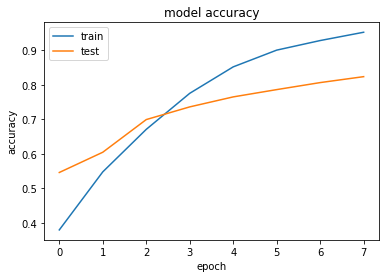

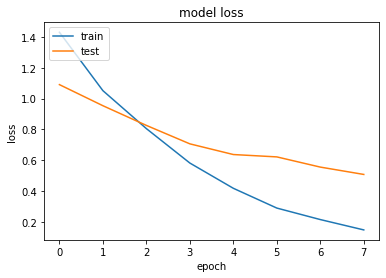

In [118]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Gráficas accuracy y loss
Visualizando estas gráficas se decide cuántas épocas se entrena finalmente. Para ello, se comprueba en qué punto la pérdida de la validación (test) llega a su mínimo antes de empezar a fluctuar.

## Entrenamiento custom

Alternativa al método .fit().

In [119]:
# train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).shuffle(4).batch(4)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).shuffle(4).batch(4)

# #Escoger métricas para medir la pérdida y exactitud del modelo. 
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# #%load_ext tensorboard 
# import datetime
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = 'logs/muva%s' % stamp
# writer = tf.summary.create_file_writer(logdir)
# EPOCHS = 15
# depth = 4

# for epoch in range(EPOCHS):

#     for images, labels in train_ds:
#         #print(images.shape, labels.shape, labels)
#         labels = tf.one_hot(labels, depth)
#         #print(labels.shape, labels)
#         with tf.GradientTape() as tape:
#             predictions = model(images)
#             loss = loss_object(labels, predictions)
#         gradients = tape.gradient(loss, model.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#         train_loss(loss)
#         acc = train_accuracy(labels, predictions)

#     for test_images, test_labels in test_ds:
#         predictions = model(images)
#         t_loss = loss_object(labels, predictions)

#         test_loss(t_loss)
#         test_accuracy(labels, predictions)

#     with writer.as_default():
#         tf.summary.scalar("acc_train",train_accuracy.result()*100.,step=epoch)
#         tf.summary.scalar("loss_train",train_loss.result()*100.,step=epoch)
#         tf.summary.scalar("acc_test",test_accuracy.result()*100.,step=epoch)
#         tf.summary.scalar("loss_test",test_loss.result()*100.,step=epoch)
#         writer.flush()

#     template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
#     print(template.format(epoch+1,
#                             train_loss.result(),
#                             train_accuracy.result()*100.,
#                             test_loss.result(),
#                             test_accuracy.result()*100.))
    
#     # Reinicia las metricas para el siguiente epoch.
#     train_loss.reset_states()
#     train_accuracy.reset_states()
#     test_loss.reset_states()
#     test_accuracy.reset_states()

## Dataset de test del Reto4

### Carga y preparación de los datos de test

In [120]:
# Lectura del split de test ordenado por su número.
class_names = ["test"]
data_path = "dataset"
chall_im_names = [(os.listdir(os.path.join(data_path, label))) for label in class_names]
[chall_im_names[i].sort(key= lambda x: (int(x[-3:]))) for i in range(len(chall_im_names))]
chall_im_names = np.hstack(np.array(chall_im_names))
print(chall_im_names[:10])

['reto4img000' 'reto4img001' 'reto4img002' 'reto4img003' 'reto4img004'
 'reto4img005' 'reto4img006' 'reto4img007' 'reto4img008' 'reto4img009']


In [121]:
X_chall = [np.array(Image.open(os.path.join(data_path, "test", name))) for name in chall_im_names]
print("Numero de imágenes de test: ", len(X_chall))

Numero de imágenes de test:  400


In [122]:
# Esto se hace por si hay imágenes un número de canales distinto a 3.
for i in range(len(X_chall)):
    h,w,c = X_chall[i].shape 
    if c != 3:
        X_chall[i] = X_chall[i][:,:,:3]

In [123]:
# Normalización y ajustar tamaño de las imagenes
for i in range(len(X_chall)):
    X_chall[i] = resize_rescales(X_chall[i])

In [124]:
# Cargar imagenes
chall_ds = tf.data.Dataset.from_tensor_slices((X_chall, chall_im_names)).batch(1)
model_chall = model

### Inferencia

In [125]:
# Inferencia
# Se guardan la prediccion en una imagen que seran 4 probabilidades y el nombre de la imagen.
preds = []
for images, names in chall_ds:
    predictions = model_chall(images)
    preds.append([predictions.numpy(), names.numpy()[0].decode("utf-8")])

In [126]:
# Se selecciona la etiqueta de la imagen teniendo en cuenta la probabilidad mas alta
chall_labels = []
class_names = ["aula", "cocina", "dormitorio", "oficina"]
for i in range(len(preds)):
    acc = preds[i][0][0]
    best_label = np.argmax(acc)
    chall_labels.append(class_names[best_label])
print(chall_labels[:10])
# print(chall_labels[0][0], np.round(chall_labels[0][1], 2))

['cocina', 'aula', 'aula', 'aula', 'cocina', 'aula', 'cocina', 'cocina', 'aula', 'cocina']


### Guardado de resultados del Reto4

In [127]:
np.savetxt('Reto4_Ypred.csv', chall_labels, fmt='%s', delimiter=',')

### Visualización de imágenes de test

<Figure size 3600x3600 with 0 Axes>

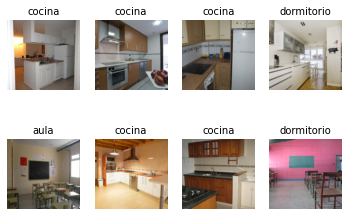

In [128]:
from numpy.random import default_rng
numb_img = 8
rng = default_rng()
numbers = rng.choice(len(preds), size=numb_img, replace=False)

class_names = ["aula", "cocina", "dormitorio", "oficina"]

plt.figure(figsize=(50,50))
f, axarr = plt.subplots(2,4)
x, y = 0, 0
for i in range(len(numbers)):
    acc = preds[numbers[i]][0][0]
    best_label = np.argmax(acc)
    # print(best_label)
    acc = np.round(acc[best_label], 2)
    label = class_names[best_label]
    axarr[x,y].imshow(X_chall[numbers[i]])
    axarr[x,y].axis('off')
    text_label = label #+ " {} %".format(str(acc))
    axarr[x,y].title.set_text(text_label) # + " %.2f %"%acc
    axarr[x,y].title.set_size(10)
    y = y + 1
    if y == axarr.shape[1]:
        y = 0
        x = x + 1
        
plt.show()